In [1]:
# Import Libraries
from PIL import Image as ImagePIL
from PIL import ImageOps
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

In [2]:
class Image:
    def __init__(self, 
                 image: str,
                 ratio: float, 
                 resize: tuple = False,
                 grayscale: bool = False) -> None:
        self.ratio = ratio
        self.resize = resize
        self.grayscale = grayscale
        
        self.image_original = ImagePIL.open(image)
        if self.resize: self.__resize(*resize)
        if self.grayscale: self.__grayscale()
        self.image_original = np.asarray(self.image_original, dtype=np.float64) / 255
        
        self.N, self.M = self.image_original.shape[:2]
        
        self.__create_mask()
        self.__mask_image()
        
    def __resize(self, width: int, height: int) -> None:
        """ @private
        Resize the image to a given size
        """
        self.image_original = self.image_original.resize((width, height))
        
    def __grayscale(self) -> None:
        """ @private
        Convert the image to grayscale (Single colour layer instead of 3)
        """
        self.image_original = ImageOps.grayscale(self.image_original)
        
    def __create_mask(self) -> None:
        """ @private
        Create the mask
        """
        self.mask_size = int(self.N * self.M * self.ratio)
        self.mask = (np.array([0] * self._get_nb_corrupt() + [1] * self._get_nb_correct()))
        np.random.shuffle(self.mask)
        self.mask = self.mask.reshape((self.N, self.M))
        
    def __mask_image(self) -> None:
        """ @private
        Create the masked image
        """
        self.image_masked = np.zeros_like(self.image_original)
        if len(self.image_original.shape) == 3:
            for i in range(3):
                self.image_masked[:, :, i] = np.multiply(self.image_original[:, :, i], self.mask)
        if len(self.image_original.shape) == 2:
            self.image_masked[:, :] = np.multiply(self.image_original[:, :], self.mask)
        
    def _get_image_original(self) -> list:
        """ @protected
        Get the original image
        """
        return self.image_original
    
    def _get_image_masked(self) -> list:
        """ @protected
        Get the masked image
        """
        return self.image_masked
    
    def _get_nb_corrupt(self) -> int:
        """ @protected
        Get the number of corrupt pixels
        """
        return self.mask_size
                     
    def _get_nb_correct(self) -> int:
        """ @protected
        Get the number of correct pixels
        """
        return self.N * self.M - self.mask_size
    
    def _get_mask(self) -> list:
        """ @protected
        Get the mask
        """
        return self.mask
    
    def visualize(self) -> None:
        """ @public
        Plotting the original and corrupted image
        """
        fig, axs = plt.subplots(1, 2, figsize=(14, 4), dpi=300)
        axs[0].title.set_text("Original Image")
        axs[0].imshow(self.image_original, cmap='gray' if self.grayscale else 'viridis')
        axs[0].set_axis_off()
        axs[1].title.set_text("In-Painted Image")
        axs[1].imshow(self.image_masked, cmap='gray' if self.grayscale else 'viridis')
        axs[1].set_axis_off()
        plt.show()

In [3]:
Img = Image(image="Houses.jpeg", ratio=0.5, resize=(256, 256), grayscale=False)
Img.visualize()

We consider the following formulation of the in-painting problem:
$$\min_{Z\in \mathcal H}\frac12\|\mathcal AZ-Z_{\text{corrupt}}\|^2+w\|Z_{(1)}\|_*+w\|Z_{(2)}\|_*$$
Where $\mathcal H=\mathbb R^{N\times M\times 3}$, $\mathcal A$ is the operator that selectes the set of correct entries of $Z$, $Z_{(1)}$ is the matrix $[Z(:,:,0)~Z(:,:,1)~Z(:,:,2)]$, $Z_{(2)}$ is the matrix $[Z(:,:,0)^T~Z(:,:,1)^T~Z(:,:,2)^T]^T$, $\|\cdot \|_*$ denotes the matrix nuclear norm and $w$ is a penality parameter.

In [23]:
class Algorithm:
    def __init__(self, image: Image, name: str) -> None:
        """
        Initial Values for Algorithm
        """
        self.image = image
        self.name = name
        
        self.Z_corrupt = self.image._get_image_masked()
        self.sol = np.zeros_like(self.Z_corrupt)
    
    def _A(self, Z: list) -> list:
        """ @protected
        The linear operator A, selecting the pixels we know to be correct
        """
        if len(Z.shape) == 3:
            AZ = np.zeros_like(Z)
            mask = self.image._get_mask()
            k = 0
            for i, j in np.ndindex(AZ.shape[:2]):
                if mask[i,j] == 1:
                    AZ[i, j, :] = Z[i, j, :]
                    k += 1
            return AZ
        elif len(Z.shape) == 2:
            AZ = np.zeros_like(Z)
            mask = self.image._get_mask()
            k = 0
            for i, j in np.ndindex(AZ.shape[:2]):
                if mask[i,j] == 1:
                    AZ[i, j] = Z[i, j]
                    k += 1
            return AZ

    def _A_adj(self, AZ: list) -> list:
        """ @protected
        The adjoint of the operator A, the zero-upsampling operator
        """
        return self._A(AZ)
    
    def _getZ1(self, Z: list) -> list:
        """ @protected
        Transforms a (N, M, 3) tensor to a (N, 3*M) tensor
        Reverses _ungetZ1
        """
        return np.hstack([np.array(Z[:, :, 0]), np.array(Z[:, :, 1]), np.array(Z[:, :, 2])])

    def _ungetZ1(self, Z1: list) -> list:
        """ @protected
        Transforms a (N, 3*M) tensor to a (N, M, 3) tensor
        Reverses _getZ1
        """
        N, M = Z1.shape
        M //= 3
        
        Z = np.zeros((N, M, 3))
        Z[:, :, 0] = Z1[:, :M]
        Z[:, :, 1] = Z1[:, M:2*M]
        Z[:, :, 2] = Z1[:, 2*M:]
        return Z
    
    def _getZ2(self, Z: list) -> list:
        """ @protected
        Transforms a (N, M, 3) tensor to a (3*N, M) tensor
        Reverses _ungetZ2
        """
        return np.vstack([np.array(Z[:, :, 0]), np.array(Z[:, :, 1]), np.array(Z[:, :, 2])])
    
    def _ungetZ2(self, Z2: list) -> list:
        """ @protected
        Transforms a (3*N, M) tensor to a (N, M, 3) tensor
        Reverses _getZ2
        """
        N, M = Z2.shape
        N //= 3
        
        Z = np.zeros((N, M, 3))
        Z[:, :, 0] = Z2[:N, :]
        Z[:, :, 1] = Z2[N:2*N, :]
        Z[:, :, 2] = Z2[2*N:, :]
        return Z
    
    def visualize(self) -> None:
        """ @public
        Visualize the results by plotting the following three images:
        - The original image, technically unaccessible
        - The in-painted image, technically the only one accessible
        - The corrected image
        """
        fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=300)
        fig.suptitle(self.name, fontsize=18)
        axs[0].title.set_text("Original Image")
        axs[0].imshow(self.image._get_image_original(), cmap='gray' if self.image.grayscale else 'viridis')
        axs[0].set_axis_off()
        axs[1].title.set_text(f"In-Painted Image ({self.image.ratio * 100} %)")
        axs[1].imshow(self.image._get_image_masked(), cmap='gray' if self.image.grayscale else 'viridis')
        axs[1].set_axis_off()
        axs[2].title.set_text(f"Corrected Image (rho={self.rho})")
        axs[2].imshow(self.sol.astype('float64'), cmap='gray' if self.image.grayscale else 'viridis')
        axs[2].set_axis_off()
        plt.show()

# Inertial Krasnoselskii-Mann Iterations (I. Fierro, J. J. Maulén and J. Peypourquet)
If we set $f(Z)=\|Z_{(1)}\|_*$, $g(Z)=\|Z_{(2)}\|_*$, $h(Z)=\frac12\|Z-Z_{\text{corrupt}}\|^2_2$ and $L=\mathcal A$, the inpainting problem fits the context of (40) of the considered paper, namely 
$$\min f(x)+g(x)+h(Lx)$$
with $f,g,h$ closed and convex, $h$ smooth, and $L$ a bounded linear map.

In [24]:
class AlgorithmIKM(Algorithm):
    
    def __init__(self, 
                 image: Image, 
                 alpha: float = 0, 
                 lamb: float = 1, 
                 rho: float = 1) -> None:
        super().__init__(image, "Inertial Krasnoselskii-Mann Iterations")
        self.alpha = alpha
        self.lamb = lamb
        self.rho = rho
                
        self.Z0 = self.Z_corrupt
        self.Z1 = self.Z_corrupt
        
    def __T(self, Z: list) -> list:
        """ @private
        Computes the linear operator T
        """
        return Z - self.__prox_g(Z) +  self.__prox_f(2 * self.__prox_g(Z) - Z - 
                                 self.rho * self._A_adj(self.__grad_h(self.__prox_g(Z))))
        
    def __prox_f(self, Z: list) -> list:
        """ @private
        f(Z) = |Z_(1)|_* (Nuclear Norm of Z_(1))
        If Z_(1) = U @ S @ V^T (SVD Decomposition) then prox_(rho*f)(Z) = U @ S_shrink @ V^T
        """
        U, S, VT = np.linalg.svd(self._getZ1(Z), full_matrices=False)
        if S.min() < 0:
            print("PROBLEM IN SVD:", S.min())
        S_shrink = np.maximum(S - self.rho, 0)
        return self._ungetZ1((U * S_shrink) @ VT)

    def __prox_g(self, Z: list) -> list:
        """ @private
        g(Z) = |Z_(2)|_* (Nuclear Norm of Z_(2))
        If Z_(2) = U @ S @ V^T (SVD Decomposition) then prox_(rho*g)(Z) = U @ S_shrink @ V^T
        """
        U, S, VT = np.linalg.svd(self._getZ2(Z), full_matrices=False)
        if S.min() < 0:
            print("PROBLEM IN SVD:", S.min())
        S_shrink = np.maximum(S - self.rho, 0)
        return self._ungetZ2((U * S_shrink) @ VT)

    def __grad_h(self, Z: list) -> list:
        """ @private
        h(Z) = |Z-Z_corrupt|^2/2
        grad(h)(Z) = Z-Z_corrupt
        """
        return Z - self.Z_corrupt

    def __iterate(self, Z0: list, Z1: list) -> tuple:
        """ @private
        Perform the iterations according to Algorithm 2
        """
        U = Z1 + self.alpha * (Z1 - Z0)
        XB = self.__prox_g(U)
        XA = self.__prox_f(2 * XB - U - self.rho * self._A_adj(self.__grad_h(self._A(XB))))
        Z2 = U + self.lamb * (XA - XB)
        return Z1, Z2
    
    def run(self, iterations: int) -> None:
        """ @public
        Run the algorithm given the number of iterations and the iterator
        """
        for i in tqdm(range(iterations)):
            self.Z0, self.Z1 = self.__iterate(self.Z0, self.Z1)
        self.sol = self.Z1

100%|██████████| 200/200 [02:59<00:00,  1.12it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


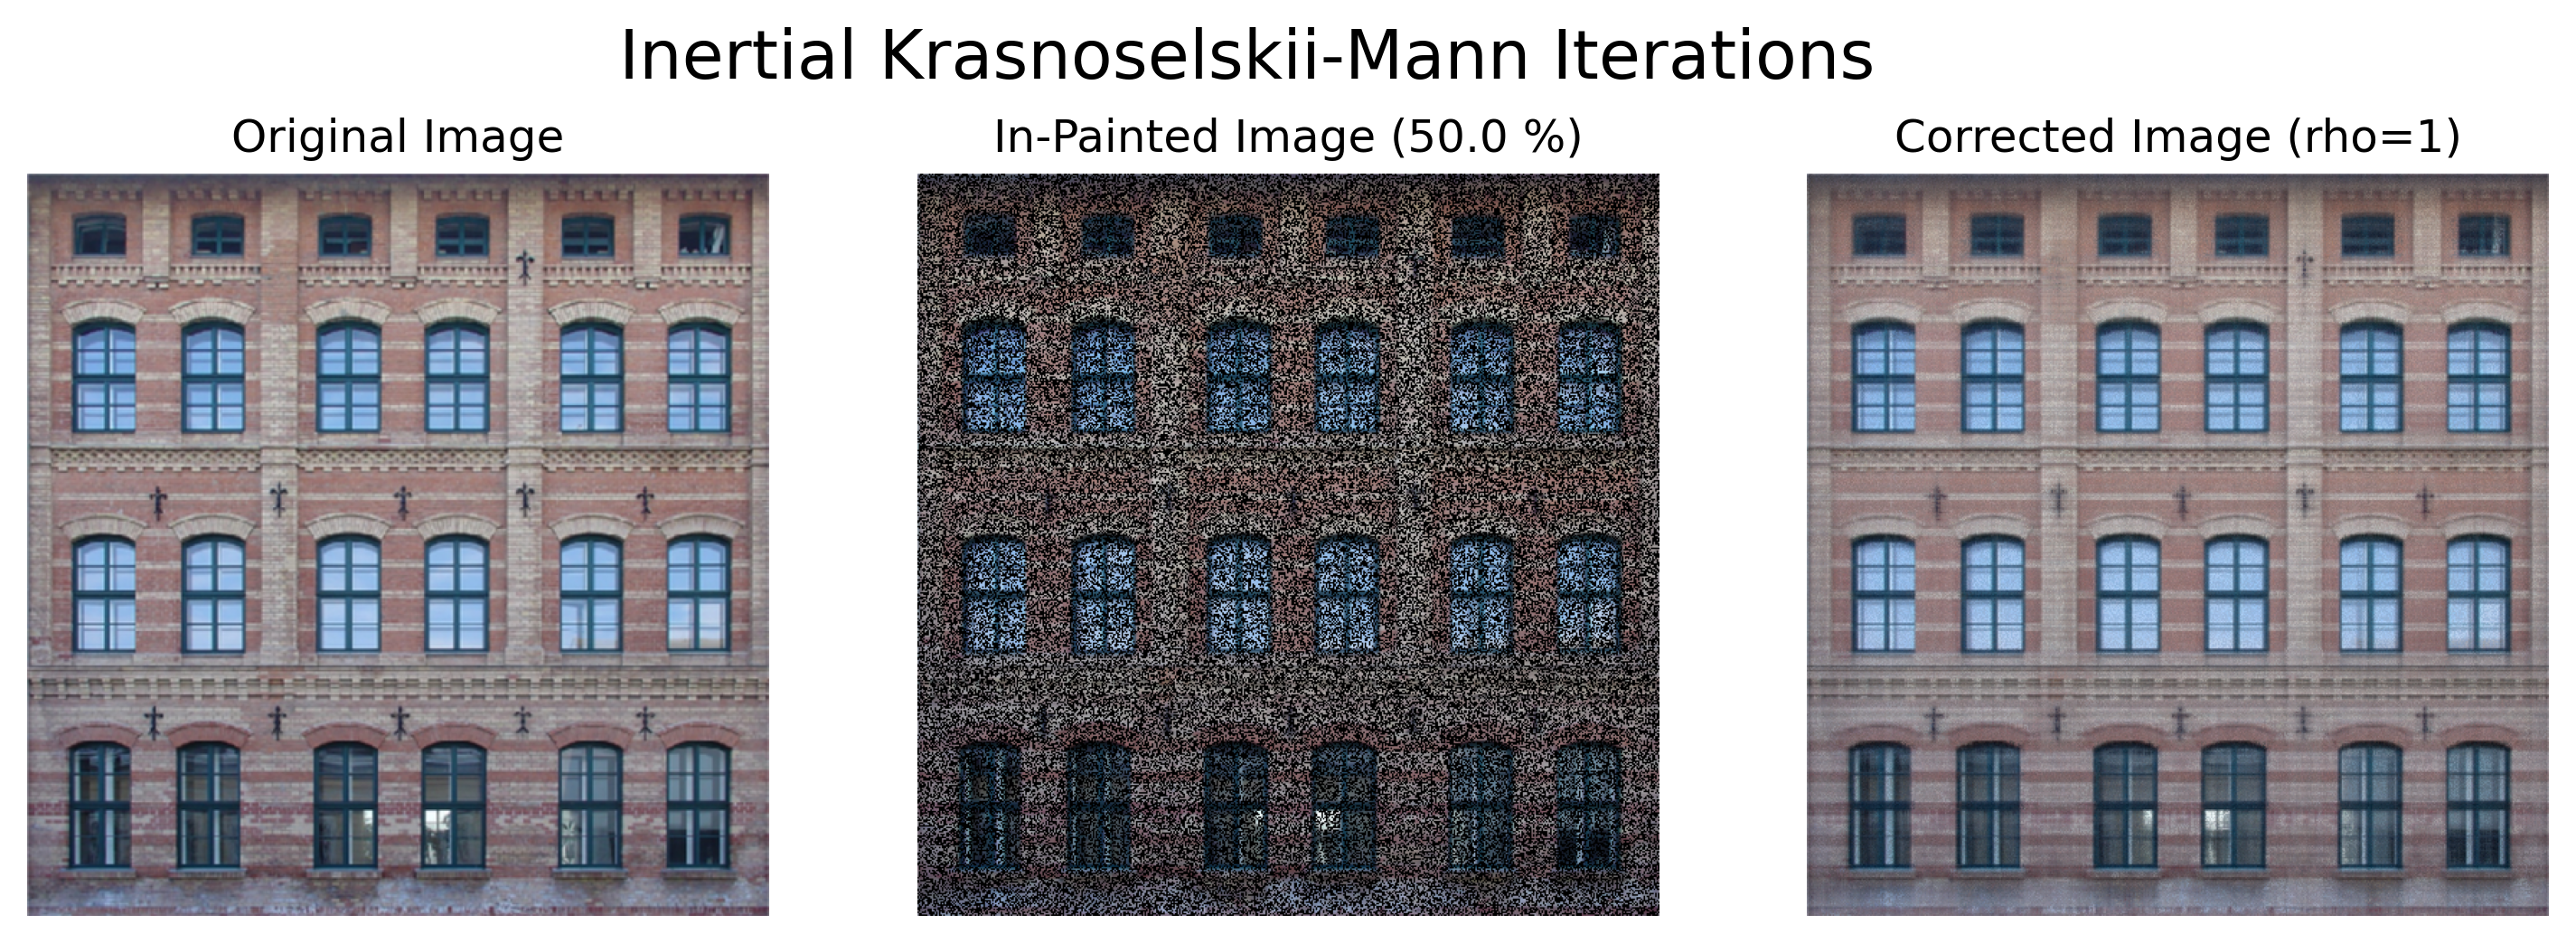

In [27]:
Img = Image(image="Houses.jpeg", ratio=0.5, resize=(516, 516))
FMP = AlgorithmIKM(image=Img, alpha=0, lamb=1, rho=1)
FMP.run(200)
FMP.visualize()